## ライブラリのインポート

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from sudachipy import dictionary, tokenizer
from tqdm import tqdm

## Word2Vec単語ベクトルの読み込み

In [20]:
word_vectors = KeyedVectors.load("../models/word2vec_vectors.kv")
print(f"語彙数: {len(word_vectors):,}語")
print(f"ベクトル次元数: {word_vectors.vector_size}")

語彙数: 195語
ベクトル次元数: 100


## データの読み込み

In [21]:
project_df = pd.read_csv("../data/raw/project-true.csv")
print(f"プロジェクトデータ: {len(project_df)}件")

user_df = pd.read_csv("../data/raw/user_work_histories.csv")
print(f"ユーザー職歴データ: {len(user_df)}件")
print(f"ユニークユーザー数: {user_df['user_id'].nunique()}名")

プロジェクトデータ: 1000件
ユーザー職歴データ: 911件
ユニークユーザー数: 300名


## テキスト処理関数の定義

### 名詞抽出関数

In [22]:
def extract_nouns(text: str) -> list[str]:
    """
    テキストから名詞を抽出する関数

    Parameters:
    -----------
    text : str
        入力テキスト

    Returns:
    --------
    nouns : list[str]
        抽出された名詞のリスト
    """
    if pd.isna(text):
        return []

    tokenizer_obj = dictionary.Dictionary(dict="full").create()
    mode = tokenizer.Tokenizer.SplitMode.C
    morphemes = tokenizer_obj.tokenize(str(text), mode)

    nouns = []
    for m in morphemes:
        pos = m.part_of_speech()[0]
        if pos == "名詞":
            nouns.append(m.surface())
    return nouns

### ドキュメントベクトル作成関数

In [23]:
def create_document_vector(text: str, word_vectors: KeyedVectors) -> np.ndarray:
    """
    テキストからドキュメントベクトルを作成する関数
    各単語のベクトルの平均を取ることでドキュメント全体のベクトルを表現

    Parameters:
    -----------
    text : str
        入力テキスト
    word_vectors : KeyedVectors
        学習済み単語ベクトル

    Returns:
    --------
    doc_vector : np.ndarray
        ドキュメントベクトル（単語ベクトルの平均）
    """
    nouns = extract_nouns(text)

    vectors = []
    for noun in nouns:
        if noun in word_vectors:
            vectors.append(word_vectors[noun])

    if len(vectors) == 0:
        return np.zeros(word_vectors.vector_size)

    return np.mean(vectors, axis=0)

## プロジェクトベクトルの作成

In [24]:
def create_project_vectors(
    project_df: pd.DataFrame, word_vectors: KeyedVectors
) -> np.ndarray:
    """プロジェクトデータからベクトル表現を作成"""
    project_vectors = []

    for idx, row in tqdm(
        project_df.iterrows(), total=len(project_df), desc="プロジェクトベクトル作成"
    ):
        combined_text = f"{row['name']} {row['description']}"
        doc_vector = create_document_vector(combined_text, word_vectors)
        project_vectors.append(doc_vector)

    return np.array(project_vectors)


project_vectors = create_project_vectors(project_df, word_vectors)
print("プロジェクトベクトルを作成しました")
print(f"形状: {project_vectors.shape}")

プロジェクトベクトル作成: 100%|██████████| 1000/1000 [00:14<00:00, 69.11it/s]

プロジェクトベクトルを作成しました
形状: (1000, 100)


## ユーザープロファイルベクトルの作成

In [25]:
def create_user_profile_vectors(
    user_df: pd.DataFrame, word_vectors: KeyedVectors
) -> tuple[np.ndarray, list[int]]:
    """
    ユーザーの職歴データからプロファイルベクトルを作成
    同一ユーザーの複数の職歴を統合して1つのベクトルにする
    """
    grouped = user_df.groupby("user_id")

    user_vectors = []
    user_ids = []

    for user_id, group in tqdm(grouped, desc="ユーザープロファイル作成"):
        all_texts = []
        for _, row in group.iterrows():
            combined_text = f"{row['project_name']} {row['description']} {row['role']}"
            all_texts.append(combined_text)

        user_text = " ".join(all_texts)
        user_vector = create_document_vector(user_text, word_vectors)

        user_vectors.append(user_vector)
        user_ids.append(user_id)

    return np.array(user_vectors), user_ids


user_vectors, user_ids = create_user_profile_vectors(user_df, word_vectors)
print("ユーザープロファイルベクトルを作成しました")
print(f"ユーザー数: {len(user_ids)}")
print(f"ベクトル形状: {user_vectors.shape}")

ユーザープロファイル作成: 100%|██████████| 300/300 [00:04<00:00, 67.36it/s]

ユーザープロファイルベクトルを作成しました
ユーザー数: 300
ベクトル形状: (300, 100)


## コサイン類似度を用いたマッチング関数の実装

In [26]:
def match_candidates_for_project(
    project_idx: int,
    project_vectors: np.ndarray,
    user_vectors: np.ndarray,
    user_ids: list[int],
    top_k: int = 10,
) -> list[tuple[int, float]]:
    """
    指定されたプロジェクトに対して、最適な人材候補をマッチング

    Parameters:
    -----------
    project_idx : int
        プロジェクトのインデックス
    project_vectors : np.ndarray
        プロジェクトベクトルの配列
    user_vectors : np.ndarray
        ユーザーベクトルの配列
    user_ids : list[int]
        ユーザーIDのリスト
    top_k : int
        上位何件の候補を返すか

    Returns:
    --------
    candidates : list[Tuple[int, float]]
        (user_id, similarity_score) のリスト（類似度の降順）
    """
    project_vector = project_vectors[project_idx].reshape(1, -1)
    similarities = cosine_similarity(project_vector, user_vectors)[0] # コサイン類似度関数
    sorted_indices = np.argsort(similarities)[::-1][:top_k]
    candidates = [(user_ids[idx], similarities[idx]) for idx in sorted_indices]

    return candidates

### 試しにプロジェクト0へのマッチングを確認

In [27]:
test_project_idx = 0
test_candidates = match_candidates_for_project(
    test_project_idx, project_vectors, user_vectors, user_ids, top_k=5
)

print(f"【テスト】プロジェクト {test_project_idx} のマッチング結果:")
print(f"プロジェクト名: {project_df.iloc[test_project_idx]['name']}")
print("\n上位5名の候補:")
for rank, (user_id, similarity) in enumerate(test_candidates, 1):
    print(f"  {rank}. ユーザーID {user_id}: 類似度 {similarity:.4f}")

【テスト】プロジェクト 0 のマッチング結果:
プロジェクト名: 旅行予約システム設計

上位5名の候補:
  1. ユーザーID 204: 類似度 0.7348
  2. ユーザーID 37: 類似度 0.7196
  3. ユーザーID 130: 類似度 0.7176
  4. ユーザーID 40: 類似度 0.7009
  5. ユーザーID 275: 類似度 0.6928


## 全プロジェクトに対するマッチング実行

In [28]:
def match_all_projects(
    project_df: pd.DataFrame,
    project_vectors: np.ndarray,
    user_vectors: np.ndarray,
    user_ids: list[int],
    top_k: int = 10,
) -> pd.DataFrame:
    """全プロジェクトに対してマッチングを実行"""
    results = []

    for project_idx in tqdm(range(len(project_df)), desc="全プロジェクトマッチング"):
        candidates = match_candidates_for_project(
            project_idx, project_vectors, user_vectors, user_ids, top_k=top_k
        )

        for rank, (user_id, similarity) in enumerate(candidates, 1):
            results.append(
                {
                    "project_id": project_df.iloc[project_idx]["id"],
                    "project_name": project_df.iloc[project_idx]["name"],
                    "rank": rank,
                    "user_id": user_id,
                    "similarity_score": similarity,
                }
            )

    return pd.DataFrame(results)

In [29]:
matching_results = match_all_projects(
    project_df, project_vectors, user_vectors, user_ids, top_k=10
)

print("マッチング完了")
print(f"総マッチング数: {len(matching_results)}件")
print("\nマッチング結果の先頭:")
matching_results.head(20)

全プロジェクトマッチング: 100%|██████████| 1000/1000 [00:00<00:00, 4083.43it/s]

マッチング完了
総マッチング数: 10000件

マッチング結果の先頭:


,project_id,project_name,rank,user_id,similarity_score
0,1,旅行予約システム設計,1,204,0.734799
1,1,旅行予約システム設計,2,37,0.719627
2,1,旅行予約システム設計,3,130,0.717594
3,1,旅行予約システム設計,4,40,0.700897
4,1,旅行予約システム設計,5,275,0.692790
5,1,旅行予約システム設計,6,161,0.690280
6,1,旅行予約システム設計,7,208,0.689299
7,1,旅行予約システム設計,8,70,0.688740
8,1,旅行予約システム設計,9,72,0.688467
9,1,旅行予約システム設計,10,120,0.686514


## マッチング結果をCSVに出力

In [30]:
output_path = "../outputs/matching_results_project_true.csv"
matching_results.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"マッチング結果を保存しました: {output_path}")

マッチング結果を保存しました: ../outputs/matching_results_project_true.csv


## 結果の詳細表示

In [31]:
def display_matching_details(project_idx: int, top_k: int = 5):
    """特定のプロジェクトのマッチング結果を詳細表示"""
    project = project_df.iloc[project_idx]
    print("=" * 80)
    print("【プロジェクト情報】")
    print(f"ID: {project['id']}")
    print(f"名前: {project['name']}")
    print(f"説明: {project['description'][:100]}...")
    print("=" * 80)

    candidates = match_candidates_for_project(
        project_idx, project_vectors, user_vectors, user_ids, top_k=top_k
    )

    print(f"\n【マッチング結果 - 上位{top_k}名】\n")

    for rank, (user_id, similarity) in enumerate(candidates, 1):
        user_histories = user_df[user_df["user_id"] == user_id]

        print(f"\n{rank}位: ユーザーID {user_id} (類似度: {similarity:.4f})")
        print("-" * 80)
        print(f"職歴数: {len(user_histories)}件")

        for i, (_, history) in enumerate(user_histories.head(3).iterrows(), 1):
            print(f"\n  職歴{i}:")
            print(f"    プロジェクト: {history['project_name']}")
            print(f"    役割: {history['role']}")
            desc = str(history["description"])[:80]
            print(f"    説明: {desc}...")

In [32]:
# サンプル表示（プロジェクト0, 1, 2）
for i in range(3):
    display_matching_details(i, top_k=3)

【プロジェクト情報】
ID: 1
名前: 旅行予約システム設計
説明: 当プロジェクトでは運用保守、テスト、デプロイ、ドキュメント作成、自動テスト導入やインフラ構築に取り組んでいる。...

【マッチング結果 - 上位3名】


1位: ユーザーID 204 (類似度: 0.7348)
--------------------------------------------------------------------------------
職歴数: 3件

  職歴1:
    プロジェクト: データ分析基盤の構築
    役割: バックエンドエンジニア
    説明: データ分析基盤の構築
[主な担当]
要件定義
チームリード
UI/UX設計
テスト実施
インフラ構築...

  職歴2:
    プロジェクト: 動画配信サービス構築
    役割: システムエンジニア
    説明: クラウド移行プロジェクト
[主な担当]
システム設計
コーディング
基本設計・詳細設計...

  職歴3:
    プロジェクト: ゲーム開発プロジェクト
    役割: インフラエンジニア
    説明: 自動テストの導入によりリリースサイクルを短縮しました。 既存システムのリファクタリングやパフォーマンスチューニングを実施しました。...

2位: ユーザーID 37 (類似度: 0.7196)
--------------------------------------------------------------------------------
職歴数: 4件

  職歴1:
    プロジェクト: セキュリティ強化プロジェクト
    役割: インフラエンジニア
    説明: ユーザビリティテストやA/Bテストを通じてUI/UXの改善を行いました。 新技術の調査やPoCを行い、アーキテクチャの改善提案を行いました。 自動テストの導入に...

  職歴2:
    プロジェクト: セキュリティ強化プロジェクト
    役割: 技術リーダー
    説明: セキュリティ強化プロジェクト
[主な担当]
環境構築
品質保証
セキュリティ対応...

  職歴3:
    プロジェクト: 金融系システム開発
    役割: フロントエンドエンジニア
    説明:

## マッチング結果の統計分析

In [33]:
print("【類似度スコアの統計】")
print(matching_results["similarity_score"].describe())

【類似度スコアの統計】
count    10000.000000
mean         0.691407
std          0.063410
min          0.453556
25%          0.651472
50%          0.695247
75%          0.737061
max          0.868954
Name: similarity_score, dtype: float64


In [34]:
print("【ランクごとの平均類似度】")
rank_similarity = matching_results.groupby("rank")["similarity_score"].mean()
print(rank_similarity)

【ランクごとの平均類似度】
rank
1     0.721087
2     0.709804
3     0.702456
4     0.695908
5     0.690485
6     0.685940
7     0.682047
8     0.678487
9     0.675405
10    0.672454
Name: similarity_score, dtype: float32


In [35]:
print("【最も推薦されたユーザー Top 10】")
top_recommended_users = matching_results["user_id"].value_counts().head(10)
print(top_recommended_users)

【最も推薦されたユーザー Top 10】
user_id
204    921
275    891
37     882
208    732
70     516
72     487
165    475
92     460
221    383
264    377
Name: count, dtype: int64


## ユーザー毎のマッチング回数の可視化

可視化を保存しました: ../outputs/user_match_counts_project_true.png


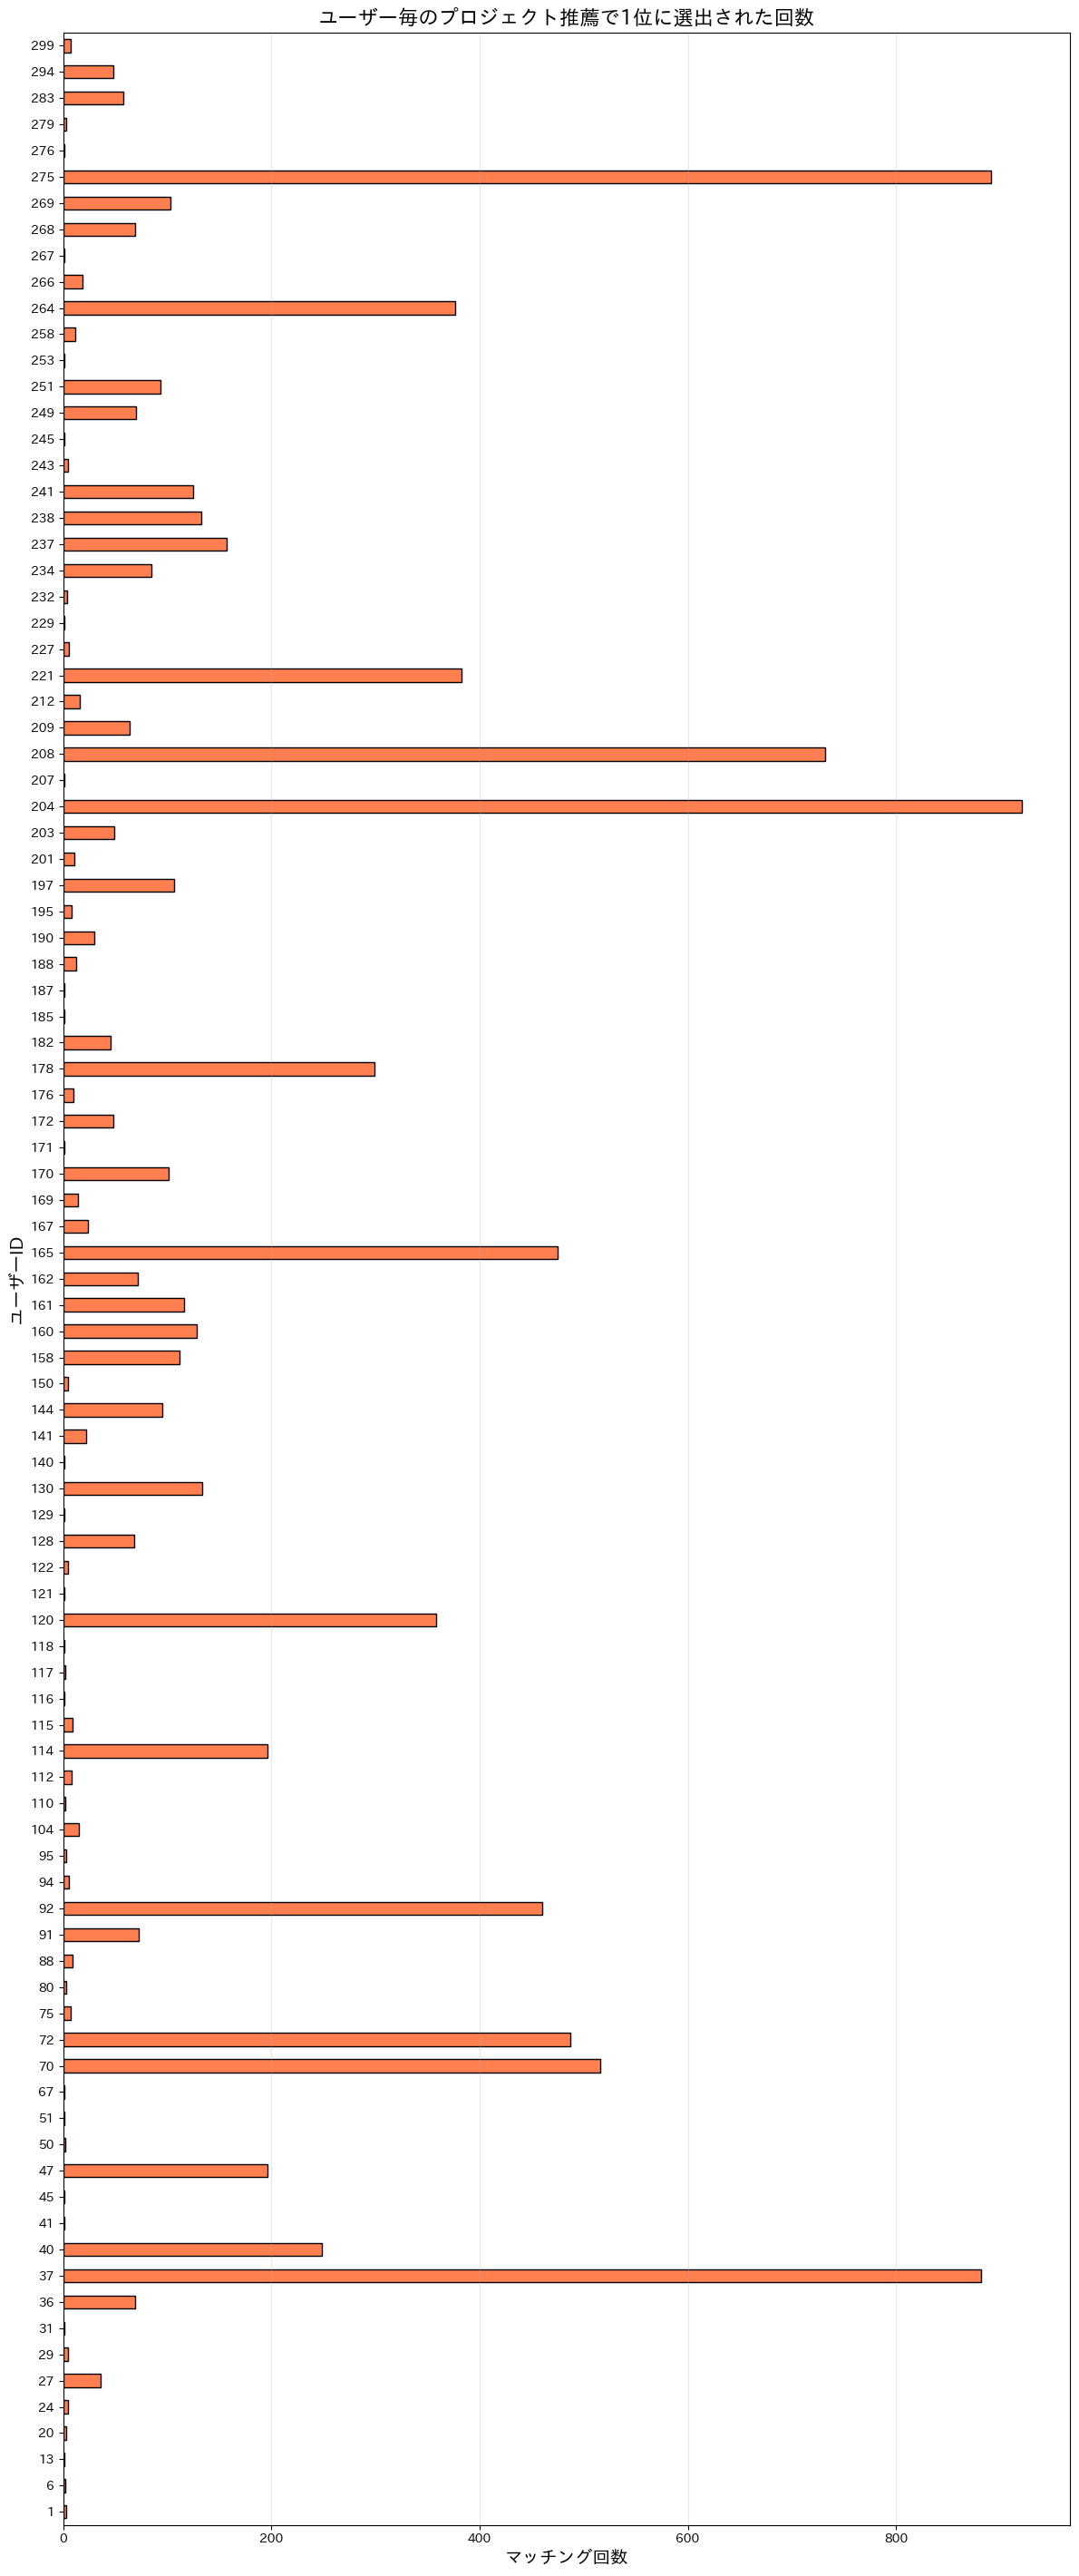

In [36]:
# ユーザー毎のマッチング回数を集計
user_match_counts = matching_results["user_id"].value_counts()

# ユーザーIDで昇順にソート
user_match_counts = user_match_counts.sort_index()

# 可視化
plt.rcParams["font.family"] = "IPAexGothic"
fig, ax = plt.subplots(figsize=(12, max(8, len(user_match_counts) * 0.3)))
user_match_counts.plot(kind="barh", ax=ax, color="coral", edgecolor="black")
ax.set_xlabel("マッチング回数", fontsize=14, fontweight="bold")
ax.set_ylabel("ユーザーID", fontsize=14, fontweight="bold")
ax.set_title(
    "ユーザー毎のプロジェクト推薦で1位に選出された回数", fontsize=16, fontweight="bold"
)
ax.grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.savefig("../outputs/user_match_counts_project_true.png", dpi=300, bbox_inches="tight")
print("可視化を保存しました: ../outputs/user_match_counts_project_true.png")
plt.show()